# Project 2
## Part 2 - Designing a Database Schema (35 points)

The Database Schema is presented as follows. We will explain the logic and assumptions later.

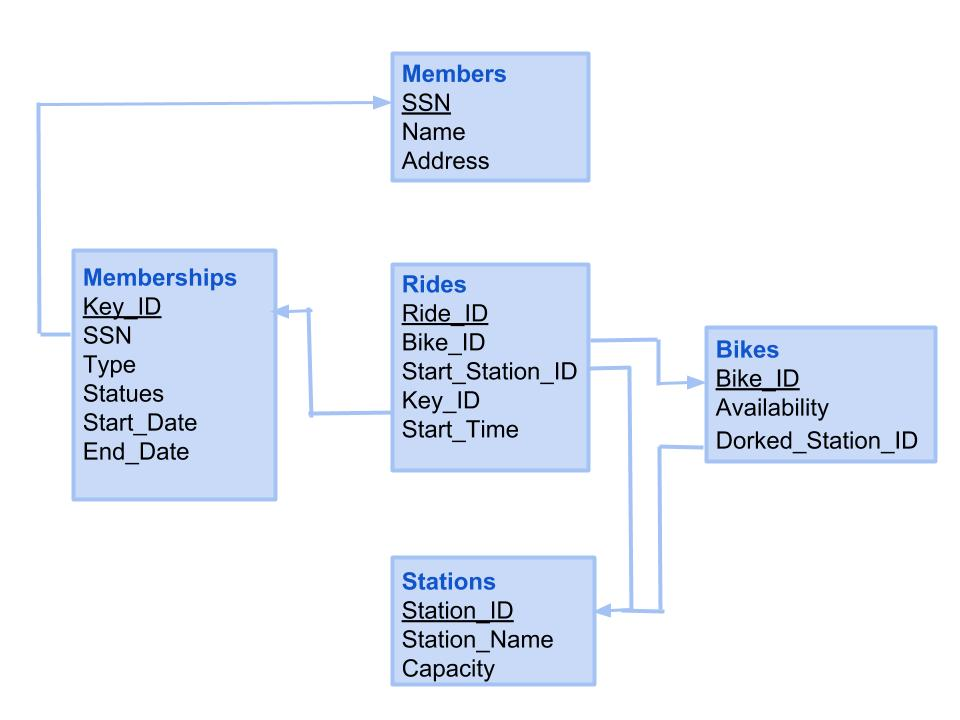

In [1]:
from IPython.display import Image
Image(filename = 'project2.jpg', width = 600, height = 600)

## Part 3

#### Problem 3.1

First, use PostgreSQL's dropdb command to drop the database named proj2, if it exists.

In [2]:
!dropdb -U student proj2

perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = (unset),
	LC_CTYPE = "UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to a fallback locale ("en_US.UTF-8").
dropdb: database removal failed: ERROR:  database "project2" does not exist


Now use PostgreSQL's createdb command to create the database named proj2.

In [3]:
!createdb -U student proj2

perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = (unset),
	LC_CTYPE = "UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to a fallback locale ("en_US.UTF-8").


Then we use sql to connect to the database we create.

In [4]:
%load_ext sql

In [5]:
%sql postgresql://student@/proj2

'Connected: student@project2'

In [6]:
!wget -O file.csv https://s3.amazonaws.com/dmfa-2017/bike_stations.csv

--2018-10-12 23:25:42--  https://s3.amazonaws.com/dmfa-2017/bike_stations.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.65.51
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.65.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169879 (166K) [text/csv]
Saving to: ‘file.csv’

file.csv            100%[===================>] 165.90K  --.-KB/s    in 0.004s  

2018-10-12 23:25:42 (38.1 MB/s) - ‘file.csv’ saved [169879/169879]



First, we take a look at a sample of the data to determine its attributes' domains and ranges.

We designed 5 tables to manage the information about the new bike sharing system.

We assume that the stationID is the station that the bike is docked. A member can have several keyIDs but can only use one key at a time. The renewed keyID is only available after the previous keyID expires. Every member need to provide his name, address and SSN for the first time registration but if he renews his membership he doesn't need to provide his personal detailed information again. If a member loses his keyID, he can use his SSN number to find his keyID back.


Based on these values, we expect we can work with the following:

__1.Members__

In the table of Members.  The first column is SSN, which identify the person's identity. The name column is actually a compound object consisting of a first name and a last name. The address column is also a compound object, with this record we can send them a keyID.  SSN is the primary key constraint. These columns are of type Vachar and allow for free form data entry. 


In [6]:
%%sql

DROP TABLE IF EXISTS Members;

CREATE TABLE Members (
    SSN      VARCHAR(20) NOT NULL PRIMARY KEY,
    Name     VARCHAR(60) NOT NULL, 
    Address  VARCHAR(60) NOT NULL
); 

 * postgresql://student@/project2
Done.
Done.


[]

In the table of Memberships, the primary key is Key ID. SSN is marked as a foreign key. KeyID can be used to check out bikes at any bike station. The Type column contains annual, semiannual or monthly membership. The statues contains active and inactive. The start date column shows when the membership starts. The end date shows the time when the membership expires. A member becomes inactive when his membership expires, therefore we use the end date column to know his statues. Members have the option to renew their memberships before they expire. However, if the membership has expired, the person will get another key when he or she apply again.


In [7]:
%%sql

DROP TABLE IF EXISTS Memberships;

CREATE TABLE Memberships (
    Key_ID      INTEGER NOT NULL PRIMARY KEY,
    SSN         VARCHAR(20) NOT NULL REFERENCES Members,
    Type        VARCHAR(20) CHECK (Type in ('annual','semiannual','monthly')),  
    Status      CHAR(10) CHECK (status in ('active','inactive') ) ,
    Start_Date  Date NOT NULL,
    End_Date    Date NOT NULL
); 

 * postgresql://student@/project2
Done.
Done.


[]

In the table of Station, the primary key is the station number. Each station has one station number. Each bike station has a pubic name, but  in response to public requests, stations can be renamed. Each bike station have been built with a number of docking points so the station capacity column shows how many bikes it can contain, the type of ‘capacity’ column should be ‘Integer’.


In [8]:
%%sql

DROP TABLE IF EXISTS Stations;

CREATE TABLE Stations (
    Station_ID     INTEGER NOT NULL PRIMARY KEY,
    Station_Name   CHAR(100) NOT NULL,
    Capacity       INTEGER
); 

 * postgresql://student@/project2
Done.
Done.


[]

In the table of Bikes,  the primary key is the bike number. The bike availability column has 3 options: serviceable, disable and check out. Docked_Station_ID is the station where the bike is docked. Docked Station ID is a constraint that ensures that all values of Docked_Station_ID entered into the table of Bikes exist in the Station table. If a bike is disabled, it is removed from the station for repair. It will show disable on this column. If a bike is using by a person, the ‘availability’ columns appears as ‘check out’, and we need to locate the last-docked station of check-out biked by the table ‘rides’. ’


In [9]:
%%sql

DROP TABLE IF EXISTS Bikes;

CREATE TABLE Bikes (
    Bike_ID                CHAR(10) NOT NULL PRIMARY KEY,
    Availability           VARCHAR(20) CHECK (availability in ('serviceable','disabled','check out') ) ,
    Docked_Station_ID      INTEGER REFERENCES Stations(Station_ID)
); 

 * postgresql://student@/project2
Done.
Done.


[]

In the table of Rides, the primary key is RideID.  RideID identifies the unique event that one active member check out one bike.Bike ID column suggests which bike is rent by the user. Start Station ID is the location where the bike is rent. Start time suggests when the bike is rent. We can update the information whenever a bike is checked out by a member. By using  RideID and Start time to know who has checked it out and when.


In [10]:
%%sql
DROP TABLE IF EXISTS Rides;

CREATE TABLE Rides (
    Ride_ID             INTEGER NOT NULL PRIMARY KEY,
    Bike_ID             CHAR(10) NOT NULL ,
    Start_Station_ID    INTEGER NOT NULL REFERENCES Stations(Station_ID),
    Key_ID              INTEGER NOT NULL REFERENCES Memberships(Key_ID),
    Start_Time          Timestamp NOT NULL
); 

 * postgresql://student@/project2
Done.
Done.


[]

#### Problem 3.2 Fill the tables with data

In [11]:
pwd!

'/home/ubuntu'

To fill the table, we need to clean the data. For table 'Members' and 'Memberships', we create databases for 10 members and memberships and fill all the information to the tables. For'rides', we make up 3 rides based on the data given by 'files.csv', for the bikes on the rides, we change the availability on bikes table in to 'check out' and set the 'docked_station_id' into null. Lastly, we get the data from 'file.csv' with the following codes.

In [12]:
import pandas as pd 
data = pd.read_csv("file.csv") 
station = data[['Station number']+['Station name']+['Station capacity']]
station = station.drop_duplicates()

__Stations__

In [14]:
%%sql
COPY Stations FROM '/home/ubuntu/station.csv'
CSV
HEADER;

 * postgresql://student@/project2
452 rows affected.


[]

In [15]:
%%sql
SELECT * 
FROM Stations
LIMIT 5;

 * postgresql://student@/project2
5 rows affected.


station_id,station_name,capacity
32011,Maple & Ritchie Ave,28
31246,M St & Pennsylvania Ave NW,10
31408,Takoma Metro,12
31309,Fessenden St & Wisconsin Ave NW,8
31125,15th & W St NW,24


__Members__

In [16]:
%%sql
COPY Members FROM '/home/ubuntu/Members.csv'
CSV
HEADER;

 * postgresql://student@/project2
10 rows affected.


[]

In [17]:
%%sql
SELECT * 
FROM Members;

 * postgresql://student@/project2
10 rows affected.


ssn,name,address
579052106,Annmarie Aaron,4233 Fairfax Dr
577228101,Brandy Bennett,1100 Wilson Blvd
577428570,Cameron Cooper,301 Water St SE
579842899,Daina Devine,1300 Constitution Ave NW
579721097,Earleen Ernst,4212 East Capitol St NE
577928610,Fernanda Forrest,3700 O St NW
577039958,Jane Lee,0 MORGAN AVE
578926274,David Potter,120 BROAD MEADOW RD
578788989,Lily Zhang,PO BOX 217
577371597,Jack Jones,196 LINCOLN ST


__Memberships__

In [18]:
%%sql
COPY Memberships FROM '/home/ubuntu/memberships.csv'
CSV
HEADER;

 * postgresql://student@/project2
10 rows affected.


[]

In [19]:
%%sql
SELECT * 
FROM Memberships;

 * postgresql://student@/project2
10 rows affected.


key_id,ssn,type,status,start_date,end_date
1,579052106,annual,inactive,2016-10-01,2017-10-01
2,577228101,semiannual,inactive,2017-04-02,2017-10-02
3,577428570,monthly,inactive,2017-06-03,2017-07-03
4,579842899,semiannual,inactive,2017-06-04,2017-12-04
5,579721097,semiannual,active,2018-09-05,2019-03-05
6,577928610,monthly,active,2018-10-06,2018-11-06
7,577039958,annual,active,2018-10-07,2019-10-07
8,578926274,monthly,active,2018-10-07,2018-11-07
9,578788989,semiannual,active,2018-10-09,2019-04-09
10,577371597,annual,active,2017-10-10,2018-10-10


__Bikes__

In [20]:
%%sql
COPY Bikes FROM '/home/ubuntu/bike.csv'
CSV
HEADER;

 * postgresql://student@/project2
4298 rows affected.


[]

In [21]:
%%sql
SELECT * 
FROM Bikes
LIMIT 5;

 * postgresql://student@/project2
5 rows affected.


bike_id,availability,docked_station_id
W00001,serviceable,31301
W00005,serviceable,32011
W00007,serviceable,31508
W00009,serviceable,31912
W00010,serviceable,31249


__Rides__

In [22]:
%%sql
COPY Rides FROM '/home/ubuntu/rides.csv'
CSV
HEADER;

 * postgresql://student@/project2
3 rows affected.


[]

In [23]:
%%sql
SELECT * 
FROM Rides;

 * postgresql://student@/project2
3 rows affected.


ride_id,bike_id,start_station_id,key_id,start_time
67808239,W00081,31258,5,2018-10-01 08:46:00
89356789,W00129,31091,6,2018-10-02 20:46:00
35059025,W00193,31645,7,2018-10-03 09:22:00


## Part 4 - Operations (15 points)

__Problem 4.1__     
The bike 'W20131' is having mechanical problems and needs to be repaired off-site. Use SQL UPDATE statements to record the fact that this bike is no longer serviceable and has been removed from the station where it was docked at. 
     
We use WHERE to locate the row and UPDATE to record the fact.

In [24]:
%%sql
UPDATE Bikes SET availability = 'disabled', docked_station_id = NULL
WHERE bike_id = 'W20131';

 * postgresql://student@/project2
1 rows affected.


[]

In [25]:
%%sql
SELECT * FROM Bikes
WHERE bike_id = 'W20131'

 * postgresql://student@/project2
1 rows affected.


bike_id,availability,docked_station_id
W20131,disabled,None


__Problem 4.2__    
The bike station at Adams Mill & Columbia Rd NW has been expanded. Use SQL UPDATE statements to change the name of the bike station from "Adams Mill & Columbia Rd NW" to "18th & Columbia Rd NW" and increase its capacity by 10.

In [26]:
%%sql
UPDATE Stations SET station_name = '18th & Columbia Rd NW', capacity = '10'
WHERE station_name = 'Adams Mill & Columbia Rd NW'

 * postgresql://student@/project2
1 rows affected.


[]

In [27]:
%%sql
SELECT * FROM Stations
WHERE station_name = '18th & Columbia Rd NW'

 * postgresql://student@/project2
1 rows affected.


station_id,station_name,capacity
31104,18th & Columbia Rd NW,10


__Problem 4.3__    
Use SQL UPDATE and/or INSERT statements to record the transaction that an active member checked out the bike 'W00005' from station 'Maple & Ritchie Ave' at '2017-10-01 08:46:00'.

To record the ride, first we need to insert one row into Rides table. In the meantime, in the Bikes table, the availibility of the bike with bike_id of 'W00005' should be updated as 'check out' and the 'ocked_Station_ID' should be set as NULL because it is not currentlt docked at any station.

In [28]:
%%sql
Insert into Rides values('67046279','W00005','32011', '8','10/1/2017 8:46');

 * postgresql://student@/project2
1 rows affected.


[]

In [29]:
%%sql
UPDATE Bikes
SET availability = 'check out', docked_Station_ID = NULL
WHERE bike_id = 'W00005'

 * postgresql://student@/project2
1 rows affected.


[]

## Part 5 - Queries (20 points)

__Problem 5.1__   
For all members, display their name, membership type (annual, semiannual or monthly, in readable text), membership status (active or expired, boolean value is fine) and the date when the membership expires.

_Table Members and Memberships are connected by the column 'ssn'. Thus we join the two tables and display the results._

In [30]:
%%sql 
SELECT Members.name, Memberships.type, Memberships.end_date
FROM Members
JOIN Memberships 
On Members.ssn = Memberships.ssn

 * postgresql://student@/project2
10 rows affected.


name,type,end_date
Annmarie Aaron,annual,2017-10-01
Brandy Bennett,semiannual,2017-10-02
Cameron Cooper,monthly,2017-07-03
Daina Devine,semiannual,2017-12-04
Earleen Ernst,semiannual,2019-03-05
Fernanda Forrest,monthly,2018-11-06
Jane Lee,annual,2019-10-07
David Potter,monthly,2018-11-07
Lily Zhang,semiannual,2019-04-09
Jack Jones,annual,2018-10-10


__Problem 5.2__     
Display the first 10 bikes base on the bike number in ascending order. For each bike, list its status (serviceable or disabled, boolean value is fine), the station name where it is docked at if there is any, the member if the bike is currently checked out, and when it was checked out. Hint: you should see one disabled bike and one checked out bike.

To display the information mentioned, all the five tables should be connected based on their primary or foreign keys. And we use ORDER BY to show the first 10 bikes.

In [35]:
%%sql
SELECT Bikes.bike_id, Bikes.availability, Bikes.docked_station_id, Stations.station_name, Rides.start_station_id, Rides.start_time, Members.name 
FROM Memberships
JOIN Members
ON Memberships.ssn = Members.ssn 
LEFT JOIN Rides
ON Memberships.key_id = Rides.key_id
RIGHT JOIN Bikes
ON Rides.bike_id = Bikes.bike_id
LEFT JOIN Stations
ON Bikes.docked_station_id = Stations.station_id
ORDER BY Bikes.bike_id
LIMIT 10;

 * postgresql://student@/project2
10 rows affected.


bike_id,availability,station_name,start_time,name
W00001,serviceable,Ward Circle / American University,None,None
W00005,check out,None,2017-10-01 08:46:00,David Potter
W00007,serviceable,Gallaudet / 8th St & Florida Ave NE,None,None
W00009,serviceable,Mount Vernon Ave & Bruce St,None,None
W00010,serviceable,Jefferson Memorial,None,None
W00011,disabled,None,None,None
W00012,serviceable,Wilson Blvd & N Illinois St,None,None
W00013,serviceable,Lee Center,None,None
W00014,serviceable,Wilson Blvd & N Illinois St,None,None
W00015,serviceable,Saint Asaph St & Pendleton St,None,None


__Problem 5.3__    
Display the top 10 stations which currently have the most bikes docked. For each station, list the station name and the total number of bikes docked there.

_Table Stations and Bikes are connected by station id. However, some bikes such as disabled bikes and check out bikes do not have docked station, so LEFT JOIN should be used. We use COUNT and GROUP by to calculate the number of bikes docked at each stations and use ORDER BY to display the top 10 stations._

In [31]:
%%sql
SELECT Stations.station_name, COUNT(Bikes.docked_station_id) AS total
FROM Bikes
LEFT JOIN Stations 
ON Bikes.docked_station_id = Stations.station_id
GROUP BY Stations.station_name
ORDER BY total DESC
LIMIT 10;

 * postgresql://student@/project2
10 rows affected.


station_name,total
Columbus Circle / Union Station,49
14th & V St NW,41
2nd & G St NE,36
13th & D St NE,33
12th & U St NW,32
11th & Kenyon St NW,29
1st & N St SE,28
6th & H St NE,27
4th & M St SW,27
13th & H St NE,27


__Problem 5.4__    
Display the first 10 stations based on their names in ascending order. For each station, list station name and the number of available docking points accepting bike returns. Verify the numbers are correct.

_Table Stations and Bikes are connected by station id. However, some bikes such as disabled bikes and check out bikes do not have docked station, so LEFT JOIN should be used. We use COUNT and GROUP by to calculate the number of bikes docked at each stations. Number of available docking points should be calculated as 'capacity' minus 'total'_.

In [32]:
%%sql
SELECT Stations.station_name, Stations.capacity-COUNT(Bikes.docked_station_id) AS available
FROM Bikes
LEFT JOIN Stations 
ON Bikes.docked_station_id = Stations.station_id
GROUP BY Stations.station_name, Stations.capacity
ORDER BY Stations.station_name 
LIMIT 10;

 * postgresql://student@/project2
10 rows affected.


station_name,available
10th & E St NW,2
10th & Florida Ave NW,5
10th & G St NW,8
10th & K St NW,6
10th & Monroe St NE,2
10th St & Constitution Ave NW,5
10th St & L'Enfant Plaza SW,7
10th & U St NW,2
11th & F St NW,2
11th & H St NE,3
